# Genetic Algorithm for Finding the Optimal Neural Network Weights

## Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Data preparation

In [2]:
# Load the iris dataset.
iris = load_iris()
X: np.ndarray = iris.data
y: np.ndarray = iris.target

In [3]:
# Split the dataset into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [4]:
# Scale the data.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
X_train: torch.Tensor = torch.from_numpy(X_train).float()
X_test: torch.Tensor = torch.from_numpy(X_test).float()
y_train: torch.Tensor = torch.from_numpy(y_train).long()
y_test: torch.Tensor = torch.from_numpy(y_test).long()

## Model definition

In [6]:
# Create the model.
iris_model = nn.Sequential(
    nn.Linear(4, 10),
    nn.ReLU(),
    nn.Linear(10, 3),
    nn.Softmax(dim=1)
)

In [7]:
# Define the loss function.
criterion = nn.CrossEntropyLoss()

In [8]:
# Evaluate the model.
def calculate_metrics(x: torch.Tensor, yt: torch.Tensor) -> None:
    preds = iris_model(x)
    # Calculate the crossentropy loss of the trained model.
    loss = criterion(preds, yt).detach().numpy()
    print(f"Crossentropy : {loss}")
    # Calculate the classification accuracy for the trained model.
    preds = preds.detach().numpy()
    yt = yt.detach().numpy()
    acc = np.sum(np.argmax(preds, axis=1) == yt) / len(yt)
    print(f"Accuracy : {acc}")

## Implementation using our own Genetic Algorithm

In [9]:
from genalg import GeneticAlgorithm, ModelParams

In [10]:
# Move the model and data to the GPU.
iris_model = iris_model.cuda()
X_train = X_train.cuda()
y_train = y_train.cuda()

In [11]:
def load_params(model: nn.Module, params: ModelParams) -> None:
    model_params = model.state_dict()
    model_params['0.weight'] = torch.FloatTensor(params[:40].reshape(10, 4))
    model_params['0.bias'] = torch.FloatTensor(params[40:50])
    model_params['2.weight'] = torch.FloatTensor(params[50:80].reshape(3, 10))
    model_params['2.bias'] = torch.FloatTensor(params[80:])
    model.load_state_dict(model_params)

In [12]:
def on_generation(generation: int, scores: list[float]) -> None:
    print(
        f"Generation: {generation:0=3} "
        f"Best fitness: {np.max(scores):.10f} "
        f"Average fitness: {np.mean(scores):.10f} "
        f"Worst fitness: {np.min(scores):.10f}"
    )

In [13]:
def fitness_fn(solution: ModelParams) -> float:
    load_params(iris_model, solution)
    with torch.no_grad():
        outputs = iris_model(X_train)
        loss: torch.Tensor = criterion(outputs, y_train)
        fitness = 1.0 / (loss.detach().item() + 1e-8)
        # _, predicted = torch.max(outputs.data, 1)
        # fitness = (predicted == labels).sum().item() / len(labels)
    return fitness

In [24]:
# Create the GA instance
ga = GeneticAlgorithm(
    model=iris_model,
    population_size=50,
    num_generations=500,
    neuron_off_rate=1e-4,
    mutation_rate=0.01,
    elitism=True,
    fitness_fn=fitness_fn,
    on_generation=on_generation,
    on_generation_interval=50,
)

In [25]:
# Run the algorithm
ga.run()

Generation: 000 Best fitness: 1.0761024196 Average fitness: 0.8907094054 Worst fitness: 0.7420075828
Generation: 050 Best fitness: 1.3567461101 Average fitness: 1.2408524536 Worst fitness: 1.0357331569
Generation: 100 Best fitness: 1.4167434137 Average fitness: 1.3622971512 Worst fitness: 1.3072489306
Generation: 150 Best fitness: 1.4393751559 Average fitness: 1.4046085507 Worst fitness: 1.3606736056
Generation: 200 Best fitness: 1.4718256740 Average fitness: 1.4393031648 Worst fitness: 1.4058855850
Generation: 250 Best fitness: 1.4754089291 Average fitness: 1.4581164122 Worst fitness: 1.4381400922
Generation: 300 Best fitness: 1.5102116201 Average fitness: 1.4908706365 Worst fitness: 1.4668528271
Generation: 350 Best fitness: 1.5238279082 Average fitness: 1.5029978901 Worst fitness: 1.4757549218
Generation: 400 Best fitness: 1.5299053338 Average fitness: 1.5118291001 Worst fitness: 1.4805718808
Generation: 450 Best fitness: 1.5387645212 Average fitness: 1.5195484077 Worst fitness: 1.5

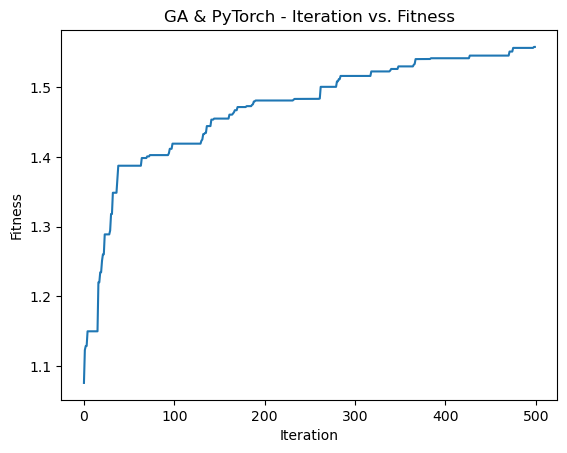

In [26]:
# Plot the fitness curve.
ga.plot_fitness()

In [27]:
# Load the weights of the best solution into the model.
best_solution = ga.best_solution
load_params(iris_model, best_solution)

In [28]:
# Move the model and data to the CPU.
iris_model = iris_model.cpu()
X_train = X_train.cpu()
y_train = y_train.cpu()

In [29]:
# Calculate the metrics of the best solution.
print("On the training set:")
calculate_metrics(X_train, y_train)
print("On the testing set:")
calculate_metrics(X_test, y_test)

On the training set:
Crossentropy : 0.6515493392944336
Accuracy : 0.9407407407407408
On the testing set:
Crossentropy : 0.6296735405921936
Accuracy : 1.0


## Implementation using PyGAD library

In [ ]:
import pygad
import pygad.torchga as torchga

In [ ]:
# Move the model and data to the CPU.
iris_model = iris_model.cpu()
X_train = X_train.cpu()
y_train = y_train.cpu()

In [6]:
# Define the parameters.
sol_per_pop = 10
num_generations = 50

In [8]:
# Create an instance of the pygad.torchga.TorchGA class to build the initial population.
torch_ga = torchga.TorchGA(
    model=iris_model,
    num_solutions=sol_per_pop,
)

In [10]:
# Some parameters are initialized within the constructor.
initial_population = torch_ga.population_weights

In [12]:
# Define the fitness function for classification.
def fitness_func(_ga: pygad.GA, sol: np.ndarray, _sol_idx: int) -> float:
    preds = torchga.predict(model=iris_model.cpu(),
                            solution=sol,
                            data=X_train)
    fitness = 1.0 / (criterion(preds, y_train).detach().numpy() + 1e-8)
    return fitness

In [164]:
# Define the callback function.
# noinspection PyShadowingNames
def on_generation(ga: pygad.GA) -> None:
    print(f'Gen#{ga.generations_completed:0=2}, Fitness: {ga.best_solution()[1]}')

In [165]:
# Create an instance of the GA class inside the ga module.
ga = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=sol_per_pop // 2,
    initial_population=initial_population,
    fitness_func=fitness_func,
    on_generation=on_generation,
)

In [166]:
# Run the genetic algorithm.
ga.run()

Gen#01, Fitness: 1.1900599037353496
Gen#02, Fitness: 1.1939120165478048
Gen#03, Fitness: 1.2502427155310072
Gen#04, Fitness: 1.2744013373097203
Gen#05, Fitness: 1.2744013373097203
Gen#06, Fitness: 1.3096510824545786
Gen#07, Fitness: 1.313579069726608
Gen#08, Fitness: 1.313579069726608
Gen#09, Fitness: 1.4125254347724279
Gen#10, Fitness: 1.4570124547086483
Gen#11, Fitness: 1.4570124547086483
Gen#12, Fitness: 1.4574750826808072
Gen#13, Fitness: 1.5130824662310964
Gen#14, Fitness: 1.570167458032895
Gen#15, Fitness: 1.570167458032895
Gen#16, Fitness: 1.570167458032895
Gen#17, Fitness: 1.570167458032895
Gen#18, Fitness: 1.5929823967826195
Gen#19, Fitness: 1.5946400303453707
Gen#20, Fitness: 1.6215502609794425
Gen#21, Fitness: 1.6215502609794425
Gen#22, Fitness: 1.6215502609794425
Gen#23, Fitness: 1.6215502609794425
Gen#24, Fitness: 1.6215502609794425
Gen#25, Fitness: 1.6215502609794425
Gen#26, Fitness: 1.6321193421385587
Gen#27, Fitness: 1.6321193421385587
Gen#28, Fitness: 1.632119342138558

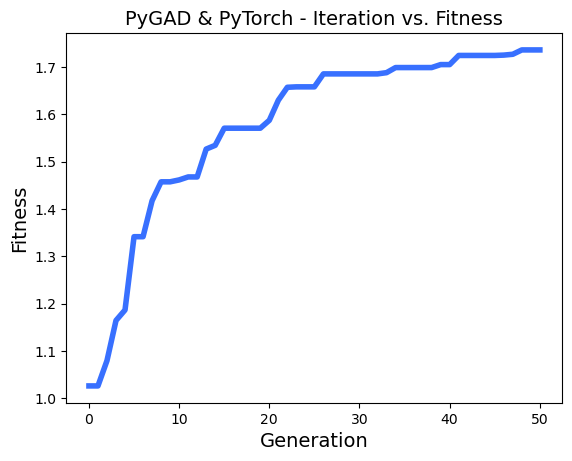

In [16]:
# After the generations complete, some plots are shown that summarize
# how the outputs/fitness values evolve over generations.
_ = ga.plot_fitness(
    title="PyGAD & PyTorch - Iteration vs. Fitness",
    linewidth=4
)

In [17]:
# Returning the details of the best solution.
best_solution, best_solution_fitness, best_solution_idx = ga.best_solution()
print(f"Fitness value of the best solution = {best_solution_fitness}")
print(f"Index of the best solution : {best_solution_idx}")

Fitness value of the best solution = 1.7365702912376162
Index of the best solution : 0


In [18]:
# Fetch the parameters of the best solution.
best_solution_weights = torchga.model_weights_as_dict(
    model=iris_model,
    weights_vector=best_solution
)
iris_model.load_state_dict(best_solution_weights)

<All keys matched successfully>

In [20]:
print("On the training set:")
calculate_metrics(X_train, y_train)

On the training set:
Crossentropy : 0.5758476853370667
Accuracy : 0.9851851851851852


In [21]:
print("On the testing set:")
calculate_metrics(X_test, y_test)

On the testing set:
Crossentropy : 0.5540574193000793
Accuracy : 1.0
